### 必要ライブラリインポート

In [12]:
import json
import os
import glob
import shutil

# 画像関係
import numpy as np
import cv2
from PIL import Image

# 画像表示
import matplotlib.pyplot as plt

IMAGE_SIZE = 256

In [5]:
# データのリスト
json_list = glob.glob('rubiksdata/*.json')
img_list = [f.replace('json', 'jpg') for f in json_list]
print(len(json_list))

32


In [6]:
no = 1

# アノテーションデータ読み込み
with open(json_list[no]) as f:
    data = json.loads(f.read())
    
# 1つだけ取り出す
shape = data['shapes'][0]
label = shape['label']
points1 = shape['points']
shape_type = shape['shape_type']
print('[label]', label)
print('[shape_type]', shape_type)
print('[points]', points1)

shape = data['shapes'][1]
label = shape['label']
points2 = shape['points']
shape_type = shape['shape_type']
print('[label]', label)
print('[shape_type]', shape_type)
print('[points]', points2)

[label] cube
[shape_type] polygon
[points] [[1395.4242424242423, 591.1515151515151], [1380.2727272727273, 600.2424242424242], [1189.3636363636363, 1130.5454545454545], [1162.090909090909, 1212.3636363636363], [1028.7575757575758, 1539.6363636363635], [1043.9090909090908, 1872.9696969696968], [1931.7878787878785, 2151.7575757575755], [2243.909090909091, 1912.3636363636363], [2319.6666666666665, 1497.2121212121212], [2422.6969696969695, 945.6969696969696]]
[label] hand
[shape_type] polygon
[points] [[7.545454545454504, 1909.3333333333333], [110.5757575757575, 1839.6363636363635], [180.27272727272725, 1788.121212121212], [319.66666666666663, 1636.6060606060605], [486.33333333333326, 1469.9393939393938], [577.2424242424242, 1351.7575757575758], [780.2727272727273, 1269.9393939393938], [849.969696969697, 1209.3333333333333], [980.2727272727273, 1066.9090909090908], [1031.7878787878788, 1030.5454545454545], [1086.3333333333333, 1030.5454545454545], [1153.0, 1076.0], [1186.3333333333333, 1136

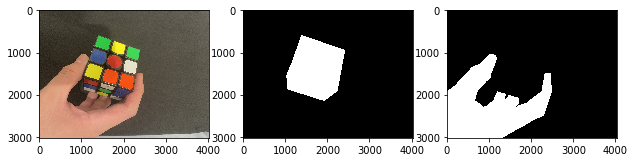

In [7]:
# 画像読み込み
img = cv2.imread(img_list[no])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# アノテーション部分
mask1 = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
mask1 = cv2.fillPoly(mask1, np.int32([points1]), 1)
mask2 = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
mask2 = cv2.fillPoly(mask2, np.int32([points2]), 2)

# 横並びに表示
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax1.imshow(img)
ax2.imshow(mask1, cmap='gray')
ax3.imshow(mask2, cmap='gray')

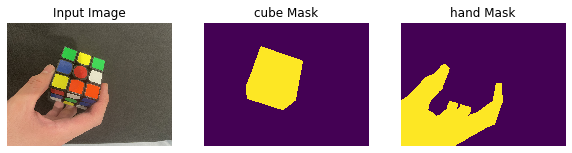

In [8]:
input_img = img                            
porigon1_img = mask1  
porigon2_img = mask2              

# 結果表示
display_list = [input_img, porigon1_img, porigon2_img]
title = ['Input Image', 'cube Mask', 'hand Mask']

plt.figure(figsize=(10, 10))
for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
plt.show()

In [9]:
# フォルダ作成 trainとvalにデータを分けます
train_dir = 'train'
val_dir = 'val'
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    os.mkdir(train_dir + '/images')
    os.mkdir(train_dir + '/masks')
if not os.path.exists(val_dir):
    os.mkdir(val_dir)
    os.mkdir(val_dir + '/images')
    os.mkdir(val_dir + '/masks')

In [10]:
# 114個のデータを用意したので 100 と 14 に分けます
for ind, file in enumerate(json_list):
    points1 = []
    points2 = []
    with open(file,encoding="utf-8") as f:
        data = json.loads(f.read())
        for s in data['shapes']:
            if s['label'] == "cube":
                points1.append(s['points'])
            else:
                points2.append(s['points'])
    
    if (points1 or points2):
        # 画像データを読み込み画像サイズ取得
        img_path = file.replace('json', 'jpg')
        img = cv2.imread(img_path)

        # ファイル名
        file_name = os.path.basename(img_path)

        # jsonのアノテーションデータ
        # 手:2
        # ルービックキューブ：1
        # 背景：0
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for p1 in points1:
            mask = cv2.fillPoly(mask, np.int32([p1]), 1)
        for p2 in points2:
            mask = cv2.fillPoly(mask, np.int32([p2]), 2)
        
        # リサイズ
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

        # 保存
        file_name = file_name.replace('jpg', 'png')
        if ind<28:
            maskim = Image.fromarray(np.uint8(mask))
            maskim.save(f'train/masks/{file_name}')
            cv2.imwrite(f'train/images/{file_name}', img)
        else:
            maskim = Image.fromarray(np.uint8(mask))
            maskim.save(f'val/masks/{file_name}')
            cv2.imwrite(f'val/images/{file_name}', img)